# HLT Chatbot Project Presentation


Simply run every cell in this notebook (Runtime -> Run all), scroll to the bottom, and wait for it to prompt you for your input. As long as you don't reset the runtime, data should be stored and retained in the database across sessions JUST SO LONG as you don't interrupt individual cells. This means that, if you want to restart the bot while retaining the same data, you should use "Runtime" -> "Restart and run all"; that will ensure that the CoreNLP environment is properly reloaded.

In [ ]:
!apt install sqlite3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  sqlite3-doc
The following NEW packages will be installed:
  sqlite3
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 752 kB of archives.
After this operation, 2,482 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 sqlite3 amd64 3.22.0-1ubuntu0.4 [752 kB]
Fetched 752 kB in 1s (1,395 kB/s)
Selecting previously unselected package sqlite3.
(Reading database ... 155501 files and directories currently installed.)
Preparing to unpack .../sqlite3_3.22.0-1ubuntu0.4_amd64.deb ...
Unpacking sqlite3 (3.22.0-1ubuntu0.4) ...
Setting up sqlite3 (3.22.0-1ubuntu0.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
import os
if not os.path.exists("bot.py"):
  print("Downloading chatbot code")
  !curl https://personal.utdallas.edu/~atm170000/HLTChatbot.zip > HLTChatbot.zip

  password = b"HLTChatbotLetsNowRunIt..."

  print("Unzipping with supplied password")
  from zipfile import ZipFile
  zf = ZipFile("HLTChatbot.zip")

  zf.extractall(".", pwd=password)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4265k  100 4265k    0     0   889k      0  0:00:04  0:00:04 --:--:--  921k
Unzipping with supplied password


In [ ]:
import glob

if not os.path.isfile("CoreNLP.zip"):
  print("Downloading Stanford CoreNLP")
  !curl -L https://nlp.stanford.edu/software/stanford-corenlp-latest.zip > CoreNLP.zip
  print("Extracting Stanford CoreNLP")
  !unzip CoreNLP.zip

  f = open("corenlp.pth", "w")
  jf_1 = glob.glob("stanford-corenlp-?.?.?/stanford-corenlp-?.?.?.jar")[0]
  jf_2 = glob.glob("stanford-corenlp-?.?.?/stanford-corenlp-?.?.?-models.jar")[0]
  f.write(jf_1 + "\n" + jf_2)
  f.close()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   355    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  481M  100  481M    0     0  5421k      0  0:01:31  0:01:31 --:--:-- 5122k
Extracting Stanford CoreNLP
Archive:  CoreNLP.zip
   creating: stanford-corenlp-4.4.0/
  inflating: stanford-corenlp-4.4.0/jaxb-api-2.4.0-b180830.0359-sources.jar  
  inflating: stanford-corenlp-4.4.0/LIBRARY-LICENSES  
  inflating: stanford-corenlp-4.4.0/slf4j-api.jar  
  inflating: stanford-corenlp-4.4.0/pom.xml  
  inflating: stanford-corenlp-4.4.0/Makefile  
  inflating: stanford-corenlp-4.4.0/stanford-corenlp-4.4.0-sources.jar  
  inflating: stanford-corenlp-4.4.0/input.txt.xml  
  inflating: stanford-corenlp-4.4.0/javax.activation-api-1.2.0.jar  
  inflating: stanford-corenlp-4.4.0/LICENSE.txt  
  inflating: stanford-corenlp-4.4.0/CoreNLP-to-HTML.xsl  
  inflating: stan

In [ ]:
!cat corenlp.pth

stanford-corenlp-4.4.0/stanford-corenlp-4.4.0.jar
stanford-corenlp-4.4.0/stanford-corenlp-4.4.0-models.jar

In [ ]:
# To run on Colab, we need to alter corenlp.py slightly to get around used Colab ports

#@markdown
f = open("corenlp.py", "w")
f.write('''
# A test script that runs the input through CoreNLP through NLTK

import atexit, sys, os, code
from nltk.parse.corenlp import CoreNLPServer, CoreNLPParser
from nltk import word_tokenize

print("Loading CoreNLP Server...")

config_file = "corenlp.pth"
if not os.path.isfile(config_file):
    warning_msg = f"Warning: {config_file} does not exist. Hopefully, the required jarfiles for Stanford CoreNLP are in the path. " + \
                  f"Otherwise, please download them from https://stanfordnlp.github.io/CoreNLP/download.html and put the paths to " + \
                  f"stanford-corenlp-X.X.X.jar and stanford-corenlp-X.X.X-models.jar as the first two lines of corenlp.pth."
    print(warning_msg, file=sys.stderr)
    corenlp_server = None
    corenlp_models = None
else:
    with open(config_file, "r") as f:
        corenlp_server = f.readline().strip()
        corenlp_models = f.readline().strip()

corenlp_options = ["-preload", "tokenize,ssplit,pos,lemma,parse,depparse,ner,openie"]

import random
port = random.randint(9000, 30000)
print("Using port", port)

corenlp_options.append("-port")
corenlp_options.append(str(port))

server = CoreNLPServer(corenlp_server, corenlp_models, corenlp_options=corenlp_options, port=port)
server.start() #(open("stdout.log", "wb"), open("stderr.log", "wb"))
atexit.register(server.stop)

parser = CoreNLPParser(server.url)

# item = list(parser.parse(word_tokenize("The end of the world is upon us, and Mario Kart 3 won't help.")))[0]

if __name__ == "__main__":
    if 'interact' in sys.argv:
        code.interact(local=locals())
    else:
        print("Enter sentences to be parsed")
        while True:
            for i, tree in enumerate(parser.parse(word_tokenize(input("> ")))):
                print(f"Tree {i+1}:")
                print(tree)
''')
f.close()

In [ ]:
# Workaround the expectation that the server will start up within thirty seconds
path = "/usr/local/lib/python3.7/dist-packages/nltk/parse/corenlp.py"
data = open(path, "r").read()
f = open(path, "w")
data = data.replace("for i in range(30):", "for i in range(90):\n            print('waiting...' + str(i + 1))\n")
data = data.replace("def try_port(port=0):\n", "def try_port(port=0):\n    return port\n")
stem = '''            raise CoreNLPServerError(
                'Could not connect to the server.'
            )'''
data = data.replace(stem, '            if self.popen.poll() is not None: print(self.popen.poll(), self.popen.communicate()[1].decode("utf-8"))\n' + stem.replace("Could", "!!Could"))
f.write(data)
f.close()

In [ ]:
# Import nltk and download necessary extra submodules
import nltk
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
print("Please note: loading CoreNLP may take up to ninety seconds.")
from bot import *

Please note: loading CoreNLP may take up to ninety seconds.
Loading CoreNLP Server...
Using port 19170
waiting...1
waiting...2
waiting...3
waiting...4
waiting...5
waiting...6
waiting...7
waiting...8
waiting...9
waiting...10
waiting...11
waiting...12
waiting...13
waiting...14
waiting...15
waiting...16
waiting...17
waiting...18
waiting...19
waiting...20
waiting...21
waiting...22
waiting...23
waiting...24
waiting...25
waiting...26
waiting...27
waiting...28
waiting...29
waiting...30
waiting...31
waiting...32
waiting...33
waiting...34


In [ ]:
import requests

## Live Demonstration.
Disable the cell under this one in order to run the in-class demonstration instead. If the bot crashes at any point (especially with a ConnectionError), try to use Runtime -> Restart Runtime and Run All (or similar). This *should* preserve the database, as it's saved automatically. If you Factory Reset Runtime, however, the database will be deleted.

In [ ]:
DISABLE_LIVE_DEMO = False #@param {"type": "boolean"}

warning_message = """
Due to bugs with Google Colab (CoreNLP *REALLY* doesn't like being run here),
if you stop this cell, it will cause the internal CoreNLP server to quit. To
resolve this, if you would like to test this bot's data persistence, then
please use "Runtime" -> "Restart and run all" to restart the bot. DO NOT just
interrupt the execution or "break" a single cell, as that will likely cause a
connection error. 
"""

if not DISABLE_LIVE_DEMO:
  print("Starting bot process.")
  print(warning_message.strip())

  bot = GameBot()
  try:
    bot.loop()
  except requests.exceptions.ConnectionError:
    print("ConnectionError! Did you forget to use \"Restart and run all\" when")
    print("restarting this bot? Just interrupting (or \"quit\"ting and rerunning the cell) won't work!")

Starting bot process.
Due to bugs with Google Colab (CoreNLP *REALLY* doesn't like being run here),
if you stop this cell, it will cause the internal CoreNLP server to quit. To
resolve this, if you would like to test this bot's data persistence, then
please use "Runtime" -> "Restart and run all" to restart the bot. DO NOT just
interrupt the execution or "break" a single cell, as that will likely cause a
connection error.
No username has been selected. Please enter a valid one-word username.
> tom
Your name is tom. Is this correct?
Y/n: y
Username selected: Tom
Type "logout" to log out.
Enter your prompt for GameBot. Type "quit" to quit.
> Who am I?
1 responses matched your query:
Tom is deep trouble
Enter your prompt for GameBot. Type "quit" to quit.
> Forget about me,
I've removed everything related to tom.
Enter your prompt for GameBot. Type "quit" to quit.
> What am I?
I'm afraid that I don't know much about that.
Enter your prompt for GameBot. Type "quit" to quit.
> I am a human.
I

## In-class demonstration

Note: all interactions are typically performed through `bot.loop`, which will interact with the user automatically. We're just interacting using other methods in the Bot class for testing and presentation purposes.

In [ ]:
bot = GameBot()

Welcome back Tom. Type "logout" to log out.


In [ ]:
bot.ensure_username()

First-order facts

In [ ]:
result = bot.process("When was Pokemon Pearl released?")

1 responses matched your query:
Pokémon Pearl was released on 2006-09-28


In [ ]:
result = bot.process("What is Minecraft's rating?")

1 responses matched your query:
Minecraft is rated 84.30574543205825


In [ ]:
# Note: it can have some issues with this if it's phrased differently, due to
#       the way CoreNLP parses the sentence.
result = bot.process("How is League of Legends rated?")

1 responses matched your query:
League of Legends is rated 80.40361596830505


In [ ]:
result = bot.process("What franchises is Minecraft part of?")

1 responses matched your query:
Minecraft is part of the following franchises:
Minecraft


In [ ]:
result = bot.process("What franchises is Pokemon Pearl part of?")

1 responses matched your query:
Pokémon Pearl is part of the following franchises:
Pokémon


In [ ]:
result = bot.process("What franchises is LEGO Star Wars part of?")

1 responses matched your query:
Lego Star Wars Ii: The Original Trilogy is part of the following franchises:
Lego


In [ ]:
result = bot.process("What franchises is League of Legends in?")

1 responses matched your query:
League Of Legends is part of the following franchises:
League Of Legends


In [ ]:
# Generic question (many Mario games); it will return everything it thinks might be helpful!
result = bot.process("When was Mario released?")

21 responses matched your query:
Mario & Luigi: Paper Jam was released on 2015-12-03
Mario & Sonic At The Olympic Games was released on 2007-11-06
Mario & Sonic At The Olympic Winter Games was released on 2009-10-13
Mario Kart 64 was released on 1996-12-14
Mario Kart 8 was released on 2014-05-29
Mario Kart Ds was released on 2005-11-05
Mario + Rabbids Kingdom Battle was released on 2017-08-29
Mario & Sonic At The London 2012 Olympic Games was released on 2011-11-15
I don't know when New Super Mario Bros. Mii was released
Paper Mario was released on 2000-08-11
Super Mario 64 was released on 1996-06-23
Super Mario Bros. was released on 1985-09-13
Super Mario Bros. 3 was released on 1988-10-23
Super Mario Bros.: The Lost Levels was released on 1986-06-03
Super Mario Land was released on 1989-04-21
Super Mario Land 2 : 6 Golden Coins was released on 1992-10-21
Super Mario Sunshine was released on 2002-07-19
Super Mario World was released on 1990-11-21
Super Mario World 2: Yoshi's Island wa

Partial Completion

In [ ]:
result = bot.process("What is Minecr's rating?")

1 responses matched your query:
Minecraft is rated 84.30574543205825


In [ ]:
# Mmm... Pokemon Pears
# Keep in mind: the RESPONSE is NOT ASCII (the accent over the "e").
#               We use fuzzy matching and special sqlite3 tables to achieve this.
result = bot.process("When was Pokemon Pear released?")

1 responses matched your query:
Pokémon Pearl was released on 2006-09-28


(Pokemon Pear, according to Google)

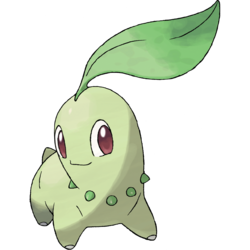

Fun Facts and General Information ("Second-order facts," sorry Organization of Programming Languages)
 - Hit or miss -- provides completely random information it learned from thousands of game descriptions
 - Often grammatically incorrect
 - Stored in an alternative OpenIE-inspred format

In [ ]:
result = bot.process("Tell me something interesting.")

Did you know: The two protagonists, trex and muscle sam, is the sons of two legends of the tag team wrestling working in the same company where their fathers had a fundamental role in its creation?
Related to game: TREX and Muscle Sam: A New Kickstart!


In [ ]:
# Previous response:
# Did you know: Drake brothers infiltrates a panamanian jail?
# Related to game: Uncharted 4: A Thief's End Special Edition
result = bot.process("What do the Drake Brothers infiltrate?")

1 responses matched your query:
Drake Brothers infiltrates a panamanian jail


In [ ]:
# From various games
result = bot.process("Who is the protagonist?")

2 responses matched your query:
The Protagonist is lemeza, a whip wielding adventurer similar to indiana jones exploring the tomb within la - mulana
The Protagonist is an ordinary 19 - year - old boy who lives in a small fishing village near suzhou -lrb- 苏州 -rrb-, china


In [ ]:
# Extremely specific information from an extremely specific description
# Did you know: The protagonist of the new legend of sword and fairy is an orphan who lives with his aunt in a small fishing village near suzhou, china?
# Related to game: New Legend of Sword and Fairy
result = bot.process("Who is the protagonist of the new legend of sword and fairy?")

1 responses matched your query:
The Protagonist Of The New Legend Of Sword And Fairy is an orphan who lives with his aunt in a small fishing village near suzhou, china


Arbitrary information (about user or anything else)

In [ ]:
result = bot.process("What is Pokemon Pearl?")

I'm afraid that I don't know much about that.


In [ ]:
result = bot.process("Pokemon Pearl is a game about diamonds and pearls.")

I'll remember that!


In [ ]:
result = bot.process("What is Pokemon Pearl?")

1 responses matched your query:
Pokemon Pearl is a game about diamonds and pearls


In [ ]:
# From a previous run, when I told it "Minecraft is a game about blocks."
result = bot.process("What is Minecraft?")

1 responses matched your query:
Minecraft is a game about blocks


In [ ]:
result = bot.process("What does Horton hear?")

I'm afraid that I don't know much about that.


In [ ]:
result = bot.process("Horton hears a Who.")

I'll remember that!


In [ ]:
result = bot.process("Who does Horton hear?")

1 responses matched your query:
Horton hears a who


About the user

In [ ]:
result = bot.process("I like Pokemon Pearl.")

I'll remember that!


In [ ]:
result = bot.process("I like Minecraft.")

I'll remember that!


In [ ]:
result = bot.process("I like Four Rhythm Across.")

I'll remember that!


In [ ]:
# Drawback! "blue" is parsed as an adjective, but "the color gold" seems to be
# fine. CoreNLP tree generation issue?
result = bot.process("I like the color gold.")

I'll remember that!


In [ ]:
result = bot.process("I dislike League of Legends.")

I'll remember that!


In [ ]:
result = bot.process("I dislike the color red.")

I'll remember that!


In [ ]:
result = bot.process("What do I like?")

4 responses matched your query:
Tom likes Pokémon Pearl
Tom likes Minecraft
Tom likes Aokana: Four Rhythm Across the Blue
Tom likes the color gold


In [ ]:
result = bot.process("What do I dislike?")

2 responses matched your query:
Tom dislikes League of Legends
Tom dislikes the color red


In [ ]:
result = bot.process("I am a human.")

I'll remember that!


In [ ]:
# Heh, apparently it finds a note that "Tom is [in] deep trouble" in its
# general knowledgebase. Prepositions aren't its strong suit.
result = bot.process("What am I?")

1 responses matched your query:
Tom is a human


User Model

In [ ]:
# Manually log out (without the loop)
bot.username = None
bot.set("username", "")
bot.ensure_username()

No username has been selected. Please enter a valid one-word username.
> usaid
Your name is usaid. Is this correct?
Y/n: y
Username selected: Usaid
Type "logout" to log out.


In [ ]:
result = bot.process("I am a person.")

I'll remember that!


In [ ]:
result = bot.process("What do I like?")

I'm afraid that I don't know much about that.


In [ ]:
result = bot.process("I like League of Legends.")

I'll remember that!


In [ ]:
result = bot.process("What do I like?")

1 responses matched your query:
Usaid likes League of Legends


In [ ]:
result = bot.process("What does Tom like?")

4 responses matched your query:
Tom likes Pokémon Pearl
Tom likes Minecraft
Tom likes Aokana: Four Rhythm Across the Blue
Tom likes the color gold


In [ ]:
result = bot.process("What am I?")

1 responses matched your query:
Usaid is a person


In [ ]:
result = bot.process("What is Tom?")

1 responses matched your query:
Tom is a human


All good things must come to an end

In [ ]:
# The chatbot can forget
result = bot.process("What do I like?")

1 responses matched your query:
Usaid likes League of Legends


In [ ]:
result = bot.process("Forget about me.")

I've removed everything related to usaid.


In [ ]:
result = bot.process("What do I like?")

I'm afraid that I don't know much about that.


You can do it with arbitrary facts.

In [ ]:
# "do" doesn't work, due to misattribution of the predicate
result = bot.process("Humans hurt a lot of other people.")
result = bot.process("Humans help a lot of other people.")

I'll remember that!
I'll remember that!


In [ ]:
result = bot.process("Who do humans help?")
result = bot.process("Who do humans hurt?")

1 responses matched your query:
Humans help a lot of other people
1 responses matched your query:
Humans hurt a lot of other people


In [ ]:
# TODO: Support ADJP arbitrarily
#!python3 corenlp.py

Arbitrary Facts

In [ ]:
result = bot.process("Dr. Mazidi is a legend.")

I'll remember that!


In [ ]:
result = bot.process("What is Dr. Mazidi?")

1 responses matched your query:
Dr. Mazidi is a legend


In [ ]:
result = bot.process("Dr. Mazidi passes all her students.")

I'll remember that!


In [ ]:
result = bot.process("Who does Dr. Mazidi pass?")

1 responses matched your query:
Dr. Mazidi passs all her students


You can even clear out arbitrary facts.

In [ ]:
result = bot.process("What did Notch begin?")

1 responses matched your query:
Notch begins development on may 10, 2009


In [ ]:
result = bot.process("Forget about Notch.")

I've removed everything related to notch.


In [ ]:
result = bot.process("What did Notch begin?")

I'm afraid that I don't know much about that.


Database examination

In [ ]:
!echo "SELECT name FROM games ORDER BY rating DESC LIMIT 10;" | sqlite3 games.sqlite

NASCAR Racing 2003 Season
Anstoss 3
Fate/Grand Order
Wizardry: Bane of the Cosmic Forge
Fate/hollow ataraxia
Ogre Battle 64: Person of Lordly Caliber
Super Mario World
Super Metroid
BroodStar
The Legend of Zelda: A Link to the Past


In [ ]:
!echo "SELECT subject, relation, object FROM relations LIMIT 10;" | sqlite3 games.sqlite

" alien life cycle "|play|a crucial role in the game
" arcade " fix it felix jr.|be|the basis of the disney animated movie wreck - it ralph
" colorful fighters " code shifter|feature|a brawler mini-game that allows up to 4 players to duke it out in a free - for - all
" control a short - panted' peasant' named rather dashing as peasant's quest|stumble|peasantry in his' quest '
" cytus ii "|be|a music rhythm game created by rayark games
" echo "|be|an action role playing game
" hal "|assume|the identity of a guard at the town's resort
" konpa school "|master|" command technique " style
" konpa school "|master|" command technique " style
" madagascar kartz like to move madagascar kartz ", sung by reel 2 real|be|the menu theme


In [ ]:
!echo "SELECT name FROM franchises LIMIT 10;" | sqlite3 games.sqlite

VOCALOID
NextRev
Tuned Turtle
Austin Powers
The Simpsons
Kung Fu Panda
AVARIA
Bicycle
Trivial Pursuit
Medabots
